Эта неделя посвящена построению несколько моделей и оценке их качества. Эти модели будут служить нам в качестве baseline-решений и пригодятся сразу для нескольких задач:
- Во-первых, на разработку baseline-модели не должно уходить много времени (это требование исходит из оценок затрат на проект в целом - большую часть времени все же нужно потратить на основное решение), процесс должен быть простым, на подавляющем большинстве этапов должны использоваться готовые протестированные инструменты.  Все это приводит к тому, что baseline-модели - это дешевый способ сделать грубую оценку потенциально возможного качества модели, при построении которого вероятность допущения ошибок относительно невелика.
- Во-вторых, использование моделей разного типа при построении baseline'ов позволяет на раннем этапе сделать предположения о том, какие подходы являются наиболее перспективными и приоритизировать дальнейшие эксперименты.
- Наличие baseline-моделей позволяет оценить, какой прирост качества дают различные преобразования, усложнения, оптимизации и прочие активности, которые вы предпринимаете для построения финального решения.
- Наконец, если после построение сложного решения оценка его качества будет очень сильно отличаться от оценки качества baseline-моделей, то это будет хорошим поводом поискать в решении ошибки.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')

## Предсказание "в лоб"

In [3]:
naive_prediction = train.shape[0] * [1]

In [4]:
y = train['label']

In [5]:
roc_auc_score(y, naive_prediction)

0.5

Я считаю, что стартовать нужно с самого простого. Хуже результата для ROC-AUC не найти, так как даже если мы поменяем классы местами в таком предсказании, то результат будет: 1 - 0.5 = 0.5

## Предсказания на числовых данных

In [6]:
numeric_columns = train.columns[1:191]
categorical_columns = train.columns[191:-1]

In [7]:
X_num = train[numeric_columns]

Для начала отсеим мусорные признаки, где нанов уж слишком много

In [8]:
frame = X_num.isna().sum() / 36000 * 100

In [9]:
new_tl = [str(i * 20) + '%' for i in range(6)]

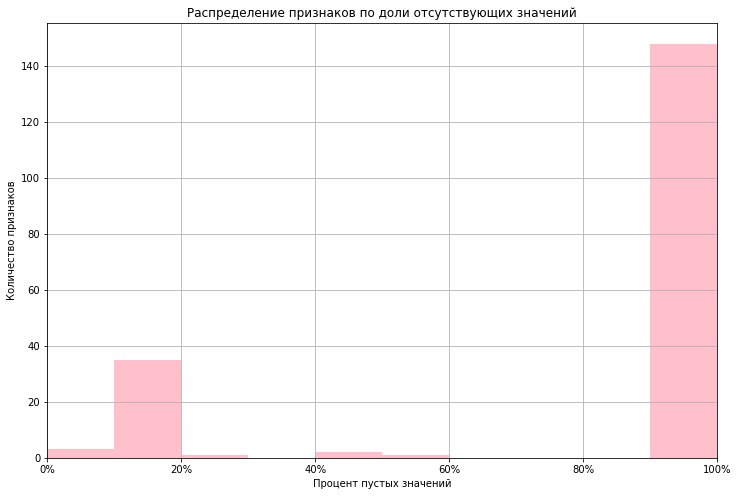

In [10]:
ax = frame.hist(color='pink', figsize=(12, 8), bins=10)
ax.set_title('Распределение признаков по доли отсутствующих значений')
ax.set_xlabel('Процент пустых значений')
ax.set_ylabel('Количество признаков')
ax.set_xbound(0, 100)
ax.set_xticklabels(new_tl);

Выбросим все признаки у которых неизвестных значений больше 20 процентов

In [11]:
good_features = frame[frame <= 20].index

Однако у нас всё еще полно пустых значений. Надо от них избавиться!

In [12]:
X_full = train[good_features]

## Наполнение nan средним значением

In [13]:
X_mean = X_full.apply(lambda x: x.fillna(x.mean()),axis=0)

In [14]:
lr = LogisticRegression(random_state=1)
res = cross_val_score(lr, X_mean, y, cv=5, scoring='roc_auc')
res.mean()

0.5317316564044091

## Наполнение nan медианой

In [15]:
X_med = X_full.apply(lambda x: x.fillna(x.median()),axis=0)

In [16]:
lr = LogisticRegression(random_state=1)
res = cross_val_score(lr, X_med, y, cv=5, scoring='roc_auc')
res.mean()

0.5280706466825189

Данные результаты лучше чем ничего, но явно не заслуживают звания baseline. Попробуем вернуть часть признаков.

In [17]:
good_features

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76',
       'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113',
       'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173',
       'Var181'],
      dtype='object')

## Подбор числа признаков

In [18]:
%%time
share = [(i+1)*0.1 for i in range(10)]
mean_vals = []
med_vals = []

for i in range(10):
    good_features = frame.sort_values()[:19*(i+1)].index
    X_full = train[good_features]
    
    X_mean = X_full.apply(lambda x: x.fillna(x.mean()),axis=0)
    lr = LogisticRegression(random_state=1)
    res = cross_val_score(lr, X_mean, y, cv=5, scoring='roc_auc')
    mean_vals.append(res.mean())
    
    X_med = X_full.apply(lambda x: x.fillna(x.median()),axis=0)
    lr = LogisticRegression(random_state=1)
    res = cross_val_score(lr, X_med, y, cv=5, scoring='roc_auc')
    med_vals.append(res.mean())

CPU times: user 3min 49s, sys: 1min 16s, total: 5min 6s
Wall time: 1min 20s


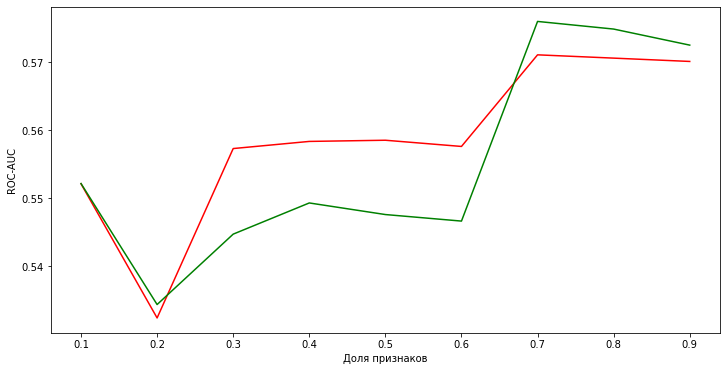

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(share, mean_vals, color='red', label='nan=mean')
plt.plot(share, med_vals, color='green', label='nan=median')
plt.xlabel('Доля признаков')
plt.ylabel('ROC-AUC');

Давайте попробуем ещё раз, но на этот раз будем подбирать коэффициент регуляризации. Отбор по количеству признаков производить больше не будем, ведь это всегда может сделать регуляризация за нас.

In [20]:
mean_vals = []
mean_f = []
med_vals = []
med_f = []
C_list = np.linspace(0.01, 5, 10)

for C in C_list:
    good_features = frame[frame != 100].index
    X_full = train[good_features]
    
    X_mean = X_full.apply(lambda x: x.fillna(x.mean()),axis=0)
    lr = LogisticRegression(C=C, random_state=1)
    res = cross_val_score(lr, X_mean, y, cv=5, scoring='roc_auc')
    mean_vals.append(res.mean())
    res = cross_val_score(lr, X_mean, y, cv=5, scoring='f1')
    mean_f.append(res.mean())
    
    X_med = X_full.apply(lambda x: x.fillna(x.median()),axis=0)
    lr = LogisticRegression(C=C, random_state=1)
    res = cross_val_score(lr, X_med, y, cv=5, scoring='roc_auc')
    med_vals.append(res.mean())
    res = cross_val_score(lr, X_med, y, cv=5, scoring='f1')
    med_f.append(res.mean())

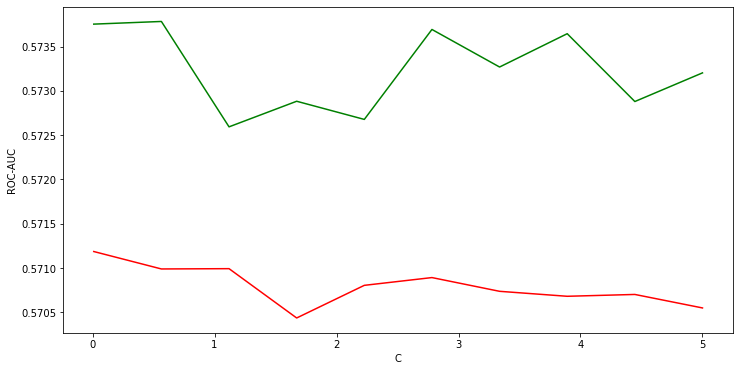

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(C_list, mean_vals, color='red', label='nan=mean')
plt.plot(C_list, med_vals, color='green', label='nan=median')
plt.xlabel('C')
plt.ylabel('ROC-AUC');

Особого улучшения не получили, но зато мы видим, что медиана ведёт себя  лучше, чем среднее значение

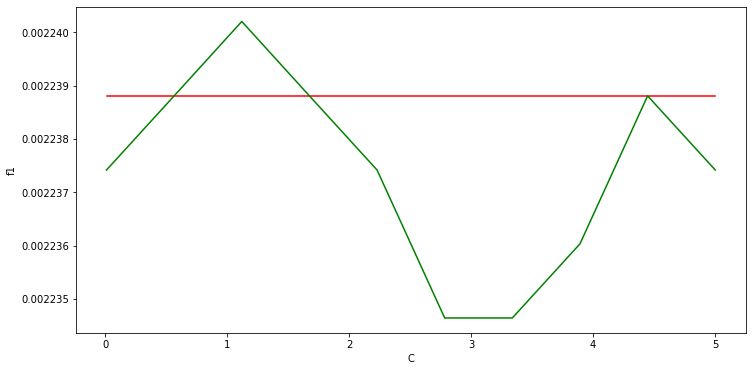

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(C_list, mean_f, color='red', label='nan=mean')
plt.plot(C_list, med_f, color='green', label='nan=median')
plt.xlabel('C')
plt.ylabel('f1');

С регрессиями ситуация явно печальная

### RandomForest

In [23]:
%%time
r_list = []
l = [i * 10 for i in range(1, 7)]
for i in range(6):
    rf = RandomForestClassifier(n_estimators=(i+1)*10, random_state=1)
    res = cross_val_score(rf, X_med, y, cv=5, scoring='roc_auc')
    r_list.append(res.mean())

CPU times: user 1min 48s, sys: 238 ms, total: 1min 48s
Wall time: 1min 48s


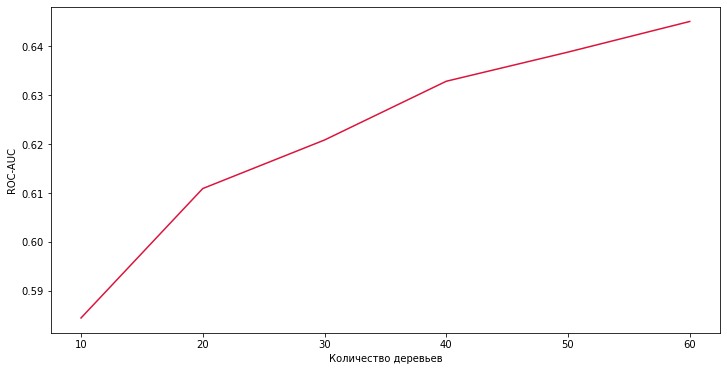

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(l, r_list, color='crimson')
plt.xlabel('Количество деревьев')
plt.ylabel('ROC-AUC');

Мы видим, что эффективность алгоритма потихоньку сходится, давайте рассчитаем ещё раз для количества деревьев, которое равно ста.

In [25]:
%%time
rf = RandomForestClassifier(100, random_state=1)
res = cross_val_score(rf, X_med, y, cv=5, scoring='roc_auc')
res_f = cross_val_score(rf, X_med, y, cv=5, scoring='f1')

CPU times: user 1min 42s, sys: 96.1 ms, total: 1min 43s
Wall time: 1min 43s


In [26]:
print('Roc-Auc for RandomForest:', res.mean())
print('F1 for RandomForest:', res_f.mean())

Roc-Auc for RandomForest: 0.6548954860902102
F1 for RandomForest: 0.0014967272218138542


## XGBClassifier

In [27]:
from xgboost import XGBClassifier

In [28]:
%%time
xgb = XGBClassifier(n_estimators=100, n_jobs=-1, objective='binary:logistic', eval_metric='logloss')
res = cross_val_score(xgb, X_med, y, cv=5, scoring='roc_auc')
res_f = cross_val_score(xgb, X_med, y, cv=5, scoring='f1')

CPU times: user 7min 17s, sys: 891 ms, total: 7min 18s
Wall time: 1min 52s


In [29]:
print('F1 for XGBClassifier:', res_f.mean())

F1 for XGBClassifier: 0.03247736424617313


In [30]:
print('Roc-Auc for XGBClassifier:', res.mean())

Roc-Auc for XGBClassifier: 0.682083104766708


Это уже приличный результат! Даже F1-метрика показала себя с лучшей стороны. Замечу, что ещё не было работы с категориальными признаками.

Резюмируем. Самую наивысшую оценку мы получили, путём конструирования нашей матрицы через только числовые признаков и выкидывания полностью пустых признаков. Далее неизвестные значения были заменены на медианы. Окончательная матрица обучилась на известном XGBClassifier.

# Надо ещё попробовать CatBoost, который возможно победит XGB!